# What does `XOR` have to do with parity?

As noted on [Wikipedia][1], parity, in this context, refers to,

> ...the evenness or oddness of the number of bits with value one within a given set of bits...It can be calculated via an XOR sum of the bits, yielding 0 for even parity and 1 for odd parity.


[1]: https://en.wikipedia.org/wiki/Parity_bit#Parity

Now that we have an understanding of the problem, let's start by solving the **first problem**:
> Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?

## Fixed length experiments.

### Create the data.

In [20]:
import random

In [21]:
def create_data(num_examples, max_seq_len, fixed_seq_len):
    bits = [0, 1]
    
    inputs = []
    outputs = []
    for _ in xrange(num_examples):
        if not fixed_seq_len:
            seq_len = random.randint(1, max_seq_len)
        else:
            seq_len = max_seq_len
            
        seq = [random.choice(bits) for _ in xrange(seq_len)]
        parity = int(sum(seq) % 2 != 0)
        
        inputs.append(seq)
        outputs.append(parity)
    return inputs, outputs

In [22]:
# Create binary sequences of length 50.
inputs, outputs = create_data(num_examples=60000, max_seq_len=50, fixed_seq_len=True)

### Build the LSTM.

In [23]:
class Model(nn.Module):
    def __init__(self, hidden_size):
        super(Model, self).__init__()
        self.LSTM = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.Linear = nn.Linear(in_features=hidden_size, out_features=1)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        outputs, _ = self.LSTM(inputs)
        outputs = self.Linear(outputs[:, -1])
        return self.Sigmoid(outputs)

### Train the LSTM.

In [25]:
def train(inputs, outputs, model, optimizer, num_iters, batch_size):
    X, y = map(np.asarray, [inputs, outputs])
    num_examples = len(X)

    losses = []
    loss_fxn = nn.BCELoss()

    for i in xrange(num_iters):
        idx = np.random.randint(num_examples, size=batch_size)
    
        X_batch = torch.FloatTensor(X[idx, :]).unsqueeze(-1)
        y_batch = torch.FloatTensor(y[idx]).unsqueeze(-1)
        X_batch = Variable(X_batch, requires_grad=True)
        y_batch = Variable(y_batch)

        predictions = model(X_batch)
        loss = loss_fxn(predictions, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data[0])
    
    return losses

In [27]:
num_iters = 2000
batch_size = 32

model = Model(hidden_size=1)
losses = train(inputs, outputs, model, optim.RMSprop(model.parameters()), num_iters, batch_size)

### Plot the training loss.

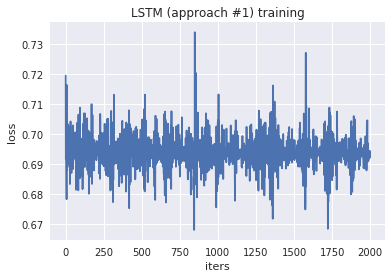

In [28]:
# Plot losses
title = 'LSTM (approach #1) training'
create_loss_plot(losses, title)

## Weird....
Despite playing with the hyperparameters and testing larger models, no model is learning. 

Interestingly, **changing the original problem slightly** allows even the simplest model to learn:

> **parity:** the evenness or oddness of the number ~~of bits with value one within a given set of bits~~ represented by the binary string

Somehow the modified problem is either simpler or more suitable for the proposed architecture.

## Modified parity problem for fixed length experiments.

### Create the data.

In [30]:
def create_simpler_data():
    num_examples = 100000
    seq_len = 50
    bits = [0, 1]
    
    inputs = []
    outputs = []
    for _ in xrange(num_examples):            
        seq = [random.choice(bits) for _ in xrange(seq_len)]
        
        # Modifiy the parity to match our new definition
        seq_str = ''.join(map(str, seq))
        value = int(seq_str, base=2)
        parity = int(value % 2 == 0)
        
        inputs.append(seq)
        outputs.append(parity)
    return inputs, outputs

In [31]:
# Create binary sequences of length 50.
simple_inputs, simple_outputs = create_simpler_data()

### Train the LSTM.

In [32]:
model = Model(hidden_size=1)
losses = train(simple_inputs, simple_outputs, model, optim.RMSprop(model.parameters()), num_iters, batch_size)

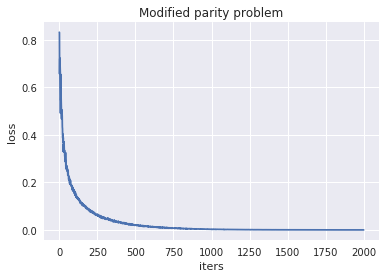

In [33]:
# Plot losses
title = 'Modified parity problem'
create_loss_plot(losses, title)

### Test accuracy.

In [34]:
def evaluate(inputs, outputs, model):
    X = torch.FloatTensor(inputs).unsqueeze(-1)
    y = torch.FloatTensor(outputs).unsqueeze(-1)

    X = Variable(X, requires_grad=True)
    y = Variable(y)

    predicitons = model(X)
    predicitons = np.around(predicitons.data.numpy())

    count = (predicitons == y.data.numpy()).sum()

    num_examples = len(X)
    accuracy = count / float(num_examples)

    return accuracy   

In [35]:
test_inputs, test_outputs = create_simpler_data()
print evaluate(test_inputs, test_outputs, model)

1.0


## Back to the original fixed length experiments.

It looks like we can train the model on shorter length sequences and it will generalize to much longer lengths.

In [54]:
inputs, outputs = create_data(num_examples=60000, max_seq_len=3, fixed_seq_len=True)

In [55]:
model = Model(hidden_size=1)
losses = train(inputs, outputs, model, optim.RMSprop(model.parameters()), num_iters, batch_size)

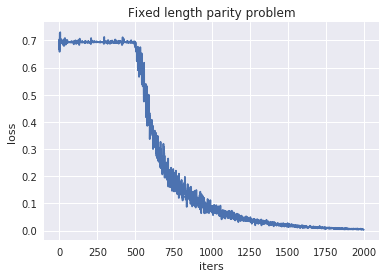

In [56]:
title = 'Fixed length parity problem'
create_loss_plot(losses, title)

In [57]:
test_inputs, test_outputs = create_data(num_examples=60000, max_seq_len=50, fixed_seq_len=True)
print evaluate(test_inputs, test_outputs, model)

1.0


# TODO:
  * are the weights interpretable?
  * intuitive terms/understadning as to why it struggles with long seq lens -> would a human and why?
  * training on seq len of 2 generalizes almost perfectly, what!
  * random search over weight space as proposed in bengio paper work?
  * how does this behavior compare with a vanilla rnn?